# Algoritmos paralelos: Pensando en paralelo
Ahora que comenzamos a ver los desafíos del paralelismo, vale la pena dar un paso atrás y examinar cómo podemos diseñar algoritmos paralelos.
Esta es una adaptación de [workshop paper](http://jiahao.github.io/parallel-prefix/) por Jiahao Chen y Alan Edelman titulado  "*Parallel Prefix Polymorphism Permits Parallelization, Presentation '&' Proof*" y aparecerá en los eventos de [First Workshop for High Performance Technical Computing in Dynamic
Languages](http://jiahao.github.io/hptcdl-sc14/) celebrada en conjunto con [SC14: The International Conference on High Performance Computing, Networking, Storage and Analysis](http://sc14.supercomputing.org/)


In [6]:
]add Pkg

    Updating registry at `C:\Users\dan_x\.julia\registries\General.toml`
   Resolving package versions...
   Installed Libiconv_jll ─ v1.16.1+2
   Installed Glib_jll ───── v2.74.0+2
    Updating `C:\Users\dan_x\.julia\environments\v1.7\Project.toml`
  [44cfe95a] + Pkg
    Updating `C:\Users\dan_x\.julia\environments\v1.7\Manifest.toml`
  [7746bdde] ↑ Glib_jll v2.74.0+1 ⇒ v2.74.0+2
  [94ce4f54] ↑ Libiconv_jll v1.16.1+1 ⇒ v1.16.1+2
Precompiling project...
  ✓ Libiconv_jll
  ✓ XML2_jll
  ✓ LightXML
  ✓ XSLT_jll
  ✓ Gettext_jll
  ✓ Xorg_libxcb_jll
  ✓ Glib_jll
  ✓ Xorg_libX11_jll
  ✓ Xorg_libXext_jll
  ✓ Xorg_libXrender_jll
  ✓ Xorg_libXfixes_jll
  ✓ Xorg_libXinerama_jll
  ✓ Libglvnd_jll
  ✓ Xorg_libXrandr_jll
  ✓ Cairo_jll
  ✓ Xorg_libXi_jll
  ✓ Xorg_libXcursor_jll
  ✓ LightOSM
  ✓ HarfBuzz_jll
  ✓ GLFW_jll
  ✓ libass_jll
  ✓ Pango_jll
  ✓ GLFW
  ✓ FFMPEG_jll
  ✓ Cairo
  ✓ FFMPEG
  ✓ Makie
  ✓ GraphMakie
  ✓ OSMMakie
  ✓ InteractiveDynamics
  ✓ CairoMakie
  ✓ GLMakie
  32 dependencies suc

In [7]:
import Pkg

In [8]:
Pkg.add("Compose")

   Resolving package versions...
    Updating `C:\Users\dan_x\.julia\environments\v1.7\Project.toml`
  [a81c6b42] + Compose v0.9.4
  No Changes to `C:\Users\dan_x\.julia\environments\v1.7\Manifest.toml`


In [9]:
Pkg.add("Gadfly")

   Resolving package versions...
  No Changes to `C:\Users\dan_x\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\dan_x\.julia\environments\v1.7\Manifest.toml`


In [10]:
using Compose, Gadfly

# `reduce()`

La reducción aplica un operador binario a un vector repetidamente para devolver un escalar. Así, + se convierte en suma y * se convierte en producto.

Se considera una primitiva de computación paralela básica.

In [11]:
reduce(+, 1:8), sum(1:8)  # triangular numbers

(36, 36)

In [12]:
reduce(*, 1:8), prod(1:8) # factorials

(40320, 40320)

In [13]:
boring(a,b)=a
@show reduce(boring, 1:8)
boring2(a,b)=b
@show reduce(boring2, 1:8)

reduce(boring, 1:8) = 1
reduce(boring2, 1:8) = 8


8

    Tambien puedes usar reduce() para calcular los numeros de fibonacci usando sus recurrencias.
$$\begin{pmatrix} f_2 \\f_1 \end{pmatrix} = \begin{pmatrix} f_1 + f_0 \\ f_1 \end{pmatrix}
= \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} f_1 \\ f_0 \end{pmatrix} $$

$$\begin{pmatrix} f_{n+1} \\ f_n \end{pmatrix} = \dots
= \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}^n \begin{pmatrix} f_1 \\ f_0 \end{pmatrix} $$

A partir de esto, puedes demostrar que
$$\begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}^n  = \begin{pmatrix} f_{n+1} & f_n \\ f_n & f_{n-1} \end{pmatrix} $$

(esto se aplica reducir al mismo argumento una y otra vez; por supuesto, hay otras formas)

In [14]:
M=[1 1; 1 0]
reduce(*,fill(M,3))
prod(fill(M,3))

2×2 Matrix{Int64}:
 3  2
 2  1

In [15]:
n= 10 #Intente manipular n para elegir diferentes valores (pruebe entre 0 y 100)
prod(fill(big.(M),n))

2×2 Matrix{BigInt}:
 89  55
 55  34

In [16]:
fib(j)=reduce(*, fill(M,j))
fib.([4,7])

2-element Vector{Matrix{Int64}}:
 [5 3; 3 2]
 [21 13; 13 8]

Puede resolver recurrencias de cualquier complejidad usando `reduce()`. Por ejemplo, `reduce()` puede calcular una matriz de Hadamard a partir de su definición en términos de sus submatrices:

$$H_2 = \begin{pmatrix} H_1 & H_1 \\ H_1 & -H_1 \end{pmatrix} = \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \otimes H_1$$

y así.

(Nota: esto es solo usar reduce para calcular una matriz de potencia.
Uno puede pensar en formas alternativas con seguridad.)

In [17]:
# Si A es m x n
# Si B es p x q
# entonces kron(A,B) es mp x nq y tiene todos los elementos de A por todos los elementos de B

In [18]:
A=[1 2;3 4]
B=[10 100; 1 -10]
⊗(A,B)=kron(A,B)

M=[ 1 1;1 -1]
H=⊗(⊗(⊗(M,M),M),M)

16×16 Matrix{Int64}:
 1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
 1  -1   1  -1   1  -1   1  -1   1  -1   1  -1   1  -1   1  -1
 1   1  -1  -1   1   1  -1  -1   1   1  -1  -1   1   1  -1  -1
 1  -1  -1   1   1  -1  -1   1   1  -1  -1   1   1  -1  -1   1
 1   1   1   1  -1  -1  -1  -1   1   1   1   1  -1  -1  -1  -1
 1  -1   1  -1  -1   1  -1   1   1  -1   1  -1  -1   1  -1   1
 1   1  -1  -1  -1  -1   1   1   1   1  -1  -1  -1  -1   1   1
 1  -1  -1   1  -1   1   1  -1   1  -1  -1   1  -1   1   1  -1
 1   1   1   1   1   1   1   1  -1  -1  -1  -1  -1  -1  -1  -1
 1  -1   1  -1   1  -1   1  -1  -1   1  -1   1  -1   1  -1   1
 1   1  -1  -1   1   1  -1  -1  -1  -1   1   1  -1  -1   1   1
 1  -1  -1   1   1  -1  -1   1  -1   1   1  -1  -1   1   1  -1
 1   1   1   1  -1  -1  -1  -1  -1  -1  -1  -1   1   1   1   1
 1  -1   1  -1  -1   1  -1   1  -1   1  -1   1   1  -1   1  -1
 1   1  -1  -1  -1  -1   1   1  -1  -1   1   1   1   1  -1  -1
 1  -1  -1   1  -1   1   1  -1  -1

In [19]:
H'H

16×16 Matrix{Int64}:
 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0  16   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0  16   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0  16   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0  16   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0  16   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0  16   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0  16   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  16   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0  16   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  16   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0  16   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0  16   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  16   0
  0   0   0   0   0

In [20]:
Hadamard(n)=reduce(⊗, fill(M,n))
H=Hadamard(4)

16×16 Matrix{Int64}:
 1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
 1  -1   1  -1   1  -1   1  -1   1  -1   1  -1   1  -1   1  -1
 1   1  -1  -1   1   1  -1  -1   1   1  -1  -1   1   1  -1  -1
 1  -1  -1   1   1  -1  -1   1   1  -1  -1   1   1  -1  -1   1
 1   1   1   1  -1  -1  -1  -1   1   1   1   1  -1  -1  -1  -1
 1  -1   1  -1  -1   1  -1   1   1  -1   1  -1  -1   1  -1   1
 1   1  -1  -1  -1  -1   1   1   1   1  -1  -1  -1  -1   1   1
 1  -1  -1   1  -1   1   1  -1   1  -1  -1   1  -1   1   1  -1
 1   1   1   1   1   1   1   1  -1  -1  -1  -1  -1  -1  -1  -1
 1  -1   1  -1   1  -1   1  -1  -1   1  -1   1  -1   1  -1   1
 1   1  -1  -1   1   1  -1  -1  -1  -1   1   1  -1  -1   1   1
 1  -1  -1   1   1  -1  -1   1  -1   1   1  -1  -1   1   1  -1
 1   1   1   1  -1  -1  -1  -1  -1  -1  -1  -1   1   1   1   1
 1  -1   1  -1  -1   1  -1   1  -1   1  -1   1   1  -1   1  -1
 1   1  -1  -1  -1  -1   1   1  -1  -1   1   1   1   1  -1  -1
 1  -1  -1   1  -1   1   1  -1  -1

In [21]:
using LinearAlgebra
cumsum(1:8)  # Es útil saber que cumsum es un operador lineal
# ¡Puedes usar el metodo power! A continuación se muestra la matriz subyacente.
A=tril(ones(Int,8,8))

8×8 Matrix{Int64}:
 1  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0
 1  1  1  0  0  0  0  0
 1  1  1  1  0  0  0  0
 1  1  1  1  1  0  0  0
 1  1  1  1  1  1  0  0
 1  1  1  1  1  1  1  0
 1  1  1  1  1  1  1  1

In [22]:
[A*(1:8),cumsum(1:8)]

2-element Vector{Vector{Int64}}:
 [1, 3, 6, 10, 15, 21, 28, 36]
 [1, 3, 6, 10, 15, 21, 28, 36]

# `prefix`

Having discussed `reduce`, we are now ready for the idea behind prefix sum.
Prefix or scan is long considered an important parallel
primitive as well.

Habiendo discutido `reduce`, ahora estamos listos para la idea detrás del prefijo sum.
El prefijo o escaneo se considera durante mucho tiempo un paralelo importante
primitivo también.

Suponga que queria calcular las sumas parciales de un vector, es decir, dado`y[1:n]`, queremos sobre escribir `y` con el vector de sumas parciales

```julia
new_y[1] = y[1]
new_y[2] = y[1] + y[2]
new_y[3] = y[1] + y[2] + y[3]
...
```
A primera vista, parece imposible paralelizar esto, ya que

```julia
new_y[1] = y[1]
new_y[2] = new_y[1] + y[2]
new_y[3] = new_y[2] + y[3]
...
```
que parece ser un proceso intrínsecamente serial. Como se escribe con un `+`
operador, esto es `cumsum`, pero tenga en cuenta que puede generalizarse a cualquier operación.

In [23]:
function prefix_serial!(y, ⊕)
    for i=2:length(y)
        y[i] = y[i-1] ⊕ y[i]
    end
    y
end

prefix_serial! (generic function with 1 method)

In [24]:
prefix_serial!([1:8;],+)

8-element Vector{Int64}:
  1
  3
  6
 10
 15
 21
 28
 36

In [25]:
cumsum(1:8)

8-element Vector{Int64}:
  1
  3
  6
 10
 15
 21
 28
 36

In [26]:
prefix_serial!([1:8;], *)

8-element Vector{Int64}:
     1
     2
     6
    24
   120
   720
  5040
 40320

In [27]:
cumprod(1:8)

8-element Vector{Int64}:
     1
     2
     6
    24
   120
   720
  5040
 40320

Sin embargo, resulta que debido a que estas operaciones son asociativas, podemos reagrupar el orden de cómo se realizan estas sumas o productos. (Esto, por supuesto, también se extiende a otras operaciones asociativas). ¡Prefix8! proporciona otra ordenación de 8 operaciones asociativas:

In [28]:
# Magic :)
function prefix8!(y, ⊕)
    length(y)==8 || error("length 8 only")
    for i in (2,4,6,8); y[i] = y[i-1] ⊕ y[i]; end
    for i in (  4,  8); y[i] = y[i-2] ⊕ y[i]; end
    for i in (      8); y[i] = y[i-4] ⊕ y[i]; end
    for i in (    6  ); y[i] = y[i-2] ⊕ y[i]; end
    for i in ( 3,5,7 ); y[i] = y[i-1] ⊕ y[i]; end
    y
end

prefix8! (generic function with 1 method)

In [29]:
prefix8!([1:8;], +) == cumsum(1:8)

true

De hecho, esto puede generalizarse más allá de las matrices de longitud 8:

In [30]:
# More magic
function prefix!(y, ⊕)
    l=length(y)
    k=ceil(Int, log2(l))
    @inbounds for j=1:k, i=2^j:2^j:min(l, 2^k)              #"reduce"
        y[i] = y[i-2^(j-1)] ⊕ y[i]
    end
    @inbounds for j=(k-1):-1:1, i=3*2^(j-1):2^j:min(l, 2^k) #"expand"
        y[i] = y[i-2^(j-1)] ⊕ y[i]
    end
    y
end

prefix! (generic function with 1 method)

In [31]:
A = rand(0:9, 123)
prefix!(copy(A), *) == cumprod(A)

true

## ¿Qué es esta magia?

Podemos visualizar las operaciones con un poco de engaño. En Julia, las matrices son simplemente tipos que exponen el protocolo de matriz. En particular, necesitan implementar métodos para las funciones genéricas `length`, `getindex` y `setindex!`. Los dos últimos se utilizan en operaciones de *indexación*, ya que las sentencias

    y = A[1]
    A[3] = y

descompemos en

    y = getindex(A, 1)
    setindex!(A, y, 3)

respectivamente.

Podemos rastrear a través del iterable introduciendo un tipo de matriz ficticia , `AccessArray`, que registra cada acceso a `getindex` y `setindex!`.

Especificamente:

- `length(A::AccessArray)` returns the length of the array it wraps regresa la longitud del arreglo que se especifica.
- `getindex(A::AccessArray, i)` registra el acceso de lectura al índice `i` en el campo `A.read` y luego devuelve el valor del arreglo especificado.
- `setindex!(A::AccessArray, x, i)` registra el acceso de escritura al índice `i`.Al campo `A.history` se le agrega una nueva tupla que consiste en el campo `A.read` actual y el índice `i`, y luego realiza la asignación.

La forma en que funciona `AccessArray` asume una asociación entre una única llamada a `setindex!` y todas las llamadas anteriores a `getindex` desde la anterior llamada a `setindex!`, lo cual es suficiente para rastrear a través de llamadas de prefijo.

In [32]:
mutable struct AccessArray{T,N,A}
    data :: A
    read :: Vector{Int}
    history :: Vector{Tuple{Vector{Int},Int}}
end
AccessArray(A) = AccessArray{eltype(A), ndims(A), typeof(A)}(A, Int[], Int[])

Base.length(A::AccessArray) = length(A.data)

function Base.getindex(A::AccessArray, i::Int)
    push!(A.read, i)
    A.data[i]
end

function Base.setindex!(A::AccessArray, x, i::Int)
    push!(A.history, (A.read, i))
    A.read = Int[]
    A.data[i] = x
end

In [33]:
M = AccessArray(rand(8))

AccessArray{Float64, 1, Vector{Float64}}([0.5072831226720147, 0.7759973268206011, 0.17598414488370573, 0.36848995885364644, 0.6297612475141482, 0.12590323780886103, 0.5786785716216403, 0.177855776002672], Int64[], Tuple{Vector{Int64}, Int64}[])

In [34]:
M[7] = M[3] + M[2]

0.9519814717043068

In [35]:
M.history

1-element Vector{Tuple{Vector{Int64}, Int64}}:
 ([3, 2], 7)

¡Así que ahora podemos rastrear el patrón de acceso al llamar a prefix8!

In [36]:
A=prefix8!(AccessArray(rand(8)),+)

AccessArray{Float64, 1, Vector{Float64}}([0.45768014074868957, 1.1241096012121958, 1.1708385989813561, 1.5220695661004353, 2.2615791215573586, 2.9922097912923427, 3.662374846173587, 4.2216887920033095], Int64[], [([1, 2], 2), ([3, 4], 4), ([5, 6], 6), ([7, 8], 8), ([2, 4], 4), ([6, 8], 8), ([4, 8], 8), ([4, 6], 6), ([2, 3], 3), ([4, 5], 5), ([6, 7], 7)])

In [38]:
A.history

11-element Vector{Tuple{Vector{Int64}, Int64}}:
 ([1, 2], 2)
 ([3, 4], 4)
 ([5, 6], 6)
 ([7, 8], 8)
 ([2, 4], 4)
 ([6, 8], 8)
 ([4, 8], 8)
 ([4, 6], 6)
 ([2, 3], 3)
 ([4, 5], 5)
 ([6, 7], 7)

¡Ahora visualicemos esto! Cada entrada en `A.history` se representa mediante un objeto de puerta:

In [40]:
using Compose: circle, mm

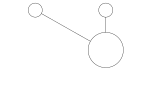

In [41]:
struct Gate{I,O}
    ins :: I
    outs :: O
end

import Gadfly.render

function render(G::Gate, x₁, y₁, y₀; rᵢ=0.1, rₒ=0.25)
    ipoints = [(i, y₀+rᵢ) for i in G.ins]
    opoints = [(i, y₀+0.5) for i in G.outs]
    igates  = [circle(i..., rᵢ) for i in ipoints]
    ogates  = [circle(i..., rₒ) for i in opoints]
    lines = [line([i, j]) for i in ipoints, j in opoints]
    compose(context(units=UnitBox(0.5,0,x₁,y₁+1)),
    compose(context(), stroke(colorant"black"), fill(colorant"white"),
            igates..., ogates...),
    compose(context(), linewidth(0.3mm), stroke(colorant"black"),
            lines...))
end

A=Gate([1,2],2)
render(A,2,0,0)

Ahora renderizamos todo el algoritmo. Tenemos que escanear el rastro dos veces; la primera vez simplemente calcula la profundidad máxima que debe dibujarse y la segunda genera los objetos.

In [42]:
function render(A::AccessArray)
    #Scan to find maximum depth
    olast = depth = 0
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        olast = maximum(y[2])
    end
    maxdepth = depth

    olast = depth = 0
    C = []
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        push!(C, render(Gate(y...), length(A), maxdepth, depth))
        olast = maximum(y[2])
    end

    push!(C, compose(context(units=UnitBox(0.5,0,length(A),1)),
      [line([(i,0), (i,1)]) for i=1:length(A)]...,
    linewidth(0.1mm), stroke(colorant"grey")))
    compose(context(), C...)
end

render (generic function with 45 methods)

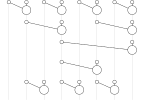

In [43]:
render(prefix!(AccessArray(zeros(8)), +))

Ahora podemos ver que `prefix!` reorganiza las operaciones para formar dos árboles de expansión:

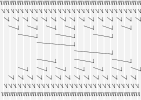

In [44]:
render(prefix!(AccessArray(zeros(120)),+))

en contraste con el código de serie:

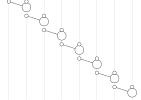

In [47]:
render(prefix_serial!(AccessArray(zeros(8)),+))

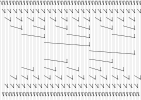

In [49]:
npp=100 # Intenta manipular npp para elegir diferentes valores entre 1 y 180
render(prefix!(AccessArray(zeros(npp)),+))

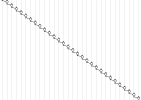

In [53]:
npp=30 # Y manupulalo de nuevo, esta vez con el algoritmo en serie
render(prefix_serial!(AccessArray(zeros(npp)),+))

# Ahora explote el paralelismo en el _algoritmo_ para usar una _implementación_ paralela

In [54]:
using .Threads
function prefix_threads!(y, ⊕)
    l=length(y)
    k=ceil(Int, log2(l))
    for j=1:k
        @threads for i=2^j:2^j:min(l, 2^k)       #"reduce"
            @inbounds y[i] = y[i-2^(j-1)] ⊕ y[i]
        end
    end
    for j=(k-1):-1:1
        @threads for i=3*2^(j-1):2^j:min(l, 2^k) #"expand"
            @inbounds y[i] = y[i-2^(j-1)] ⊕ y[i]
        end
    end
    y
end

A = rand(500_000);

using BenchmarkTools
@btime prefix_serial!($(copy(A)), +);
@btime prefix!($(copy(A)), +);
@btime prefix_threads!($(copy(A)), +);

prefix_threads!(copy(A), +) == prefix!(copy(A), +) ≈ cumsum(A)

  1.081 ms (0 allocations: 0 bytes)
  1.713 ms (0 allocations: 0 bytes)
  1.664 ms (222 allocations: 24.86 KiB)


true

# Pensando en paralelo

Observe cómo no necesitábamos contorsionarnos para hacer que nuestro algoritmo funcionara con `@threads`. Realmente _solo_ tomamos un `@threads` y funcionó. Fue preciso _y_ rápido.

Idear reordenamientos que hagan que su algoritmo particular sea compatible con el paralelo no siempre es fácil, pero cuando es posible, hace que todo lo demás se desarrolle de forma natural.

Finalmente, tenga en cuenta que puede haber formas más inteligentes de visualizar los algoritmos como pruebas de cordura.